In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sn


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_data_generators():
    train_dir = '/kaggle/input/private-datasetrar/224x224/train'
    valid_dir = '/kaggle/input/private-datasetrar/224x224/valid'
    test_dir = '/kaggle/input/private-datasetrar/224x224/test'

    batch_size = 32
    img_height, img_width = (224, 224)

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4
    )
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    valid_generator = train_datagen.flow_from_directory(
        directory=valid_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    test_generator = train_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, valid_generator, test_generator


In [3]:
def ResNetModel(input_shape, num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # set all existing layers to not trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions, name='ResNet50')

    return model


In [4]:
def compile_and_fit_model(model, train_generator, valid_generator):
    EPOCHS = 50
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath_best = '/kaggle/working/ResNet50/50epoch.{epoch:02d}-{val_loss:.2f}.h5'
    checkpoint_best = ModelCheckpoint(
        filepath=checkpoint_filepath_best,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[checkpoint_best]
    )
    return history


In [5]:
def plot_training_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot Training Accuracy and Validation Accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('ResNet Training Accuracy VS Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Training', 'Validation'])

    # Plot Training Loss and Validation Loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('ResNet Training Loss VS Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()


In [6]:
def save_best_model():
    saved_models_dir = '/kaggle/working/ResNet50/'
    saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
    saved_model_files.sort()
    best_model_file = saved_model_files[-1]
    best_model = tf.keras.models.load_model(best_model_file)

    best_model.save('/kaggle/working/ResNet50/Best_ResNet50.h5')



In [7]:
def evaluate_models(test_generator, train_generator):
    saved_model_filepaths = glob.glob('/kaggle/working/ResNet50/*.h5')

    for model_filepath in saved_model_filepaths:
        print("Model file path: {}".format(model_filepath))

        model = tf.keras.models.load_model(model_filepath)

        filenames = test_generator.filenames
        nb_samples = len(filenames)

        y_prob = []
        y_act = []

        test_generator.reset()
        for _ in range(nb_samples):
            X_test, Y_test = test_generator.next()
            y_prob.append(model.predict(X_test))
            y_act.append(Y_test)

        predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
        actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

        out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

        confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

        sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
        plt.title('Confusion Matrix for Model: {}'.format(model_filepath))
        plt.show()

        print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))


Found 1593 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.8600
Epoch 1: val_accuracy improved from -inf to 0.92779, saving model to /kaggle/working/ResNet50/50epoch.01-0.18.h5
50/50 [==============================] - 41s 634ms/step - loss: 0.5676 - accuracy: 0.8600 - val_loss: 0.1791 - val_accuracy: 0.9278
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9473
Epoch 2: val_accuracy did not improve from 0.92779
50/50 [==============================] - 27s 541ms/step - loss: 0.1316 - accuracy: 0.9473 - val_loss: 0.2754 - val_accuracy: 0.8884
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9692
Epoch 3: val_accuracy improved from 0.92779 to 0.97593, saving model to /kaggle/working/ResNet50/50ep

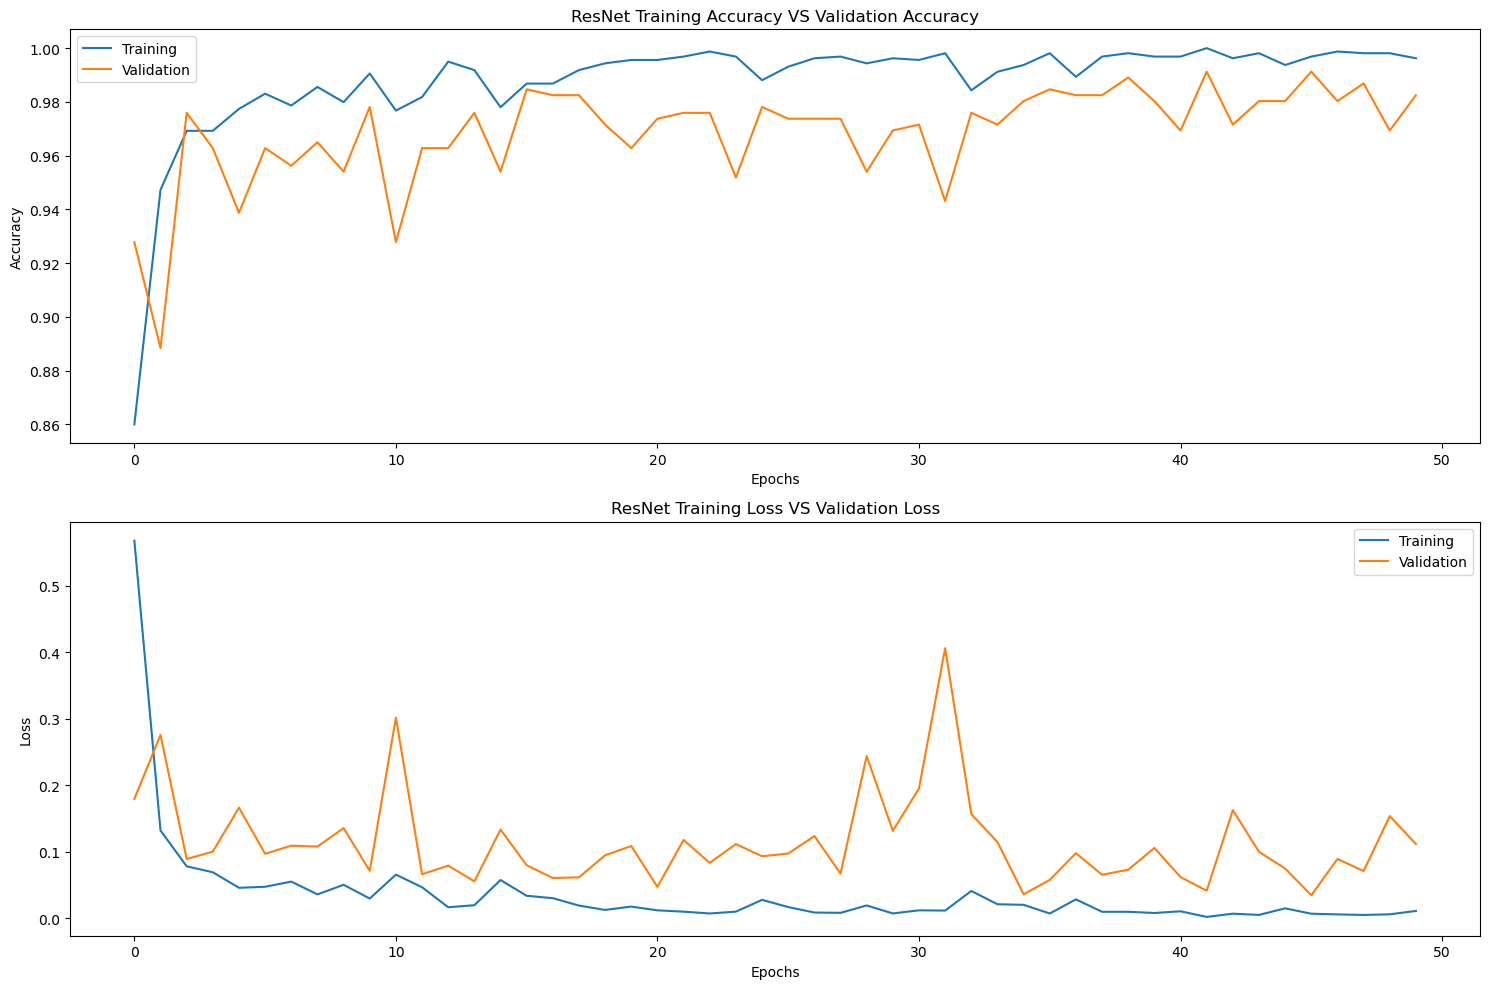

Model file path: /kaggle/working/ResNet50/50epoch.03-0.09.h5
1/1 [==============================] - 0s 24ms/step


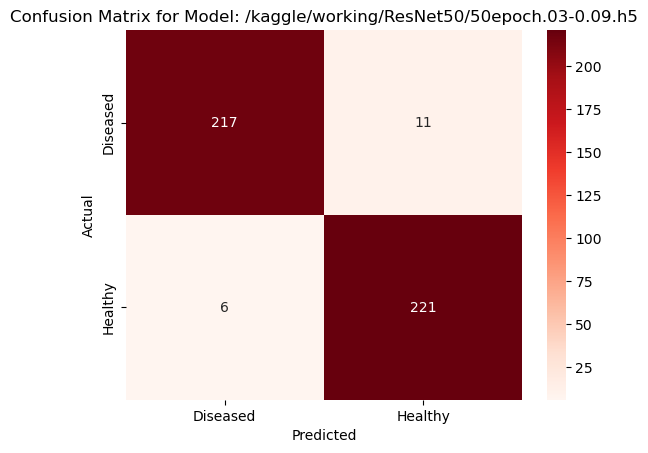

Test accuracy: 96.26373626373626
Model file path: /kaggle/working/ResNet50/50epoch.01-0.18.h5
1/1 [==============================] - 0s 38ms/step


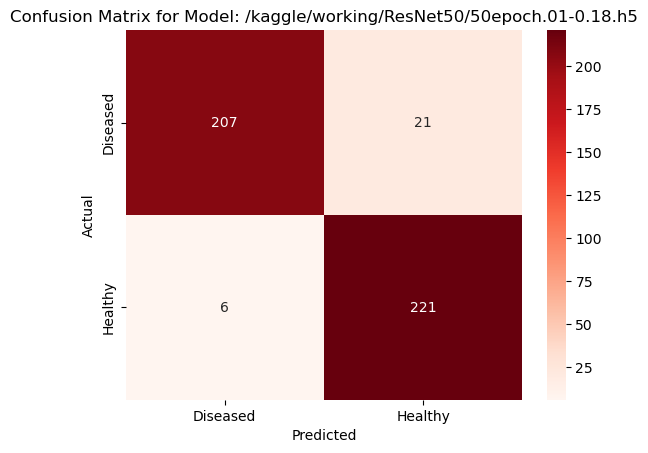

Test accuracy: 94.06593406593406
Model file path: /kaggle/working/ResNet50/50epoch.42-0.04.h5
1/1 [==============================] - 0s 23ms/step


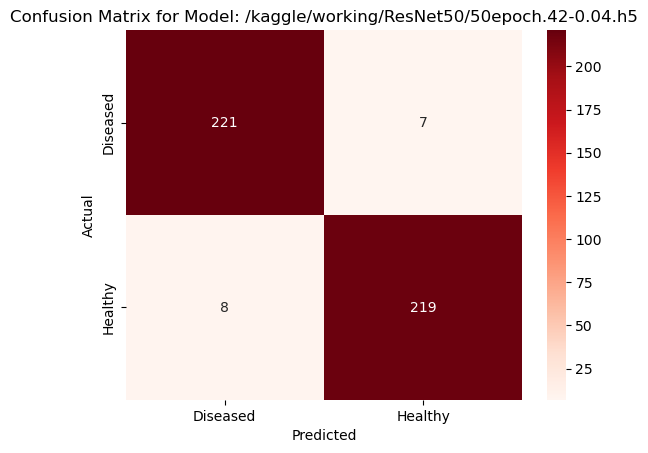

Test accuracy: 96.7032967032967
Model file path: /kaggle/working/ResNet50/50epoch.16-0.08.h5
1/1 [==============================] - 0s 24ms/step


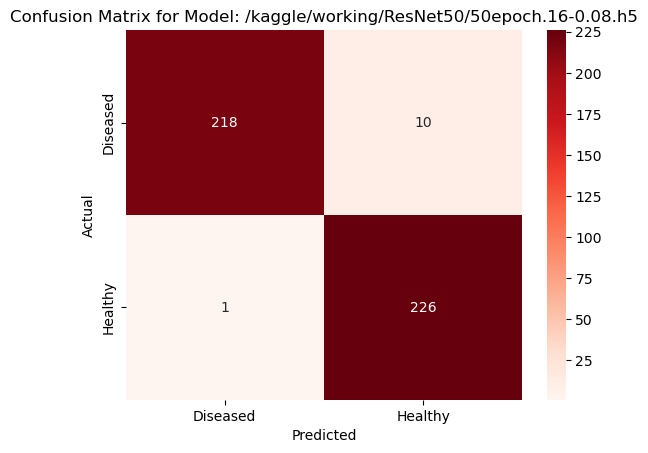

Test accuracy: 97.58241758241758
Model file path: /kaggle/working/ResNet50/50epoch.10-0.07.h5
1/1 [==============================] - 0s 23ms/step


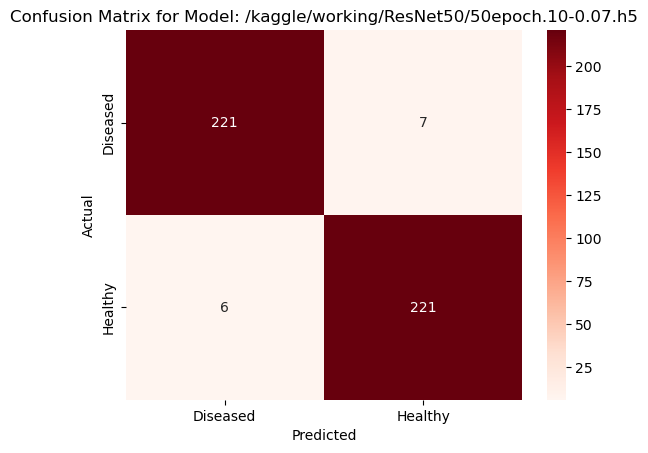

Test accuracy: 97.14285714285714
Model file path: /kaggle/working/ResNet50/Best_ResNet50.h5
1/1 [==============================] - 0s 23ms/step


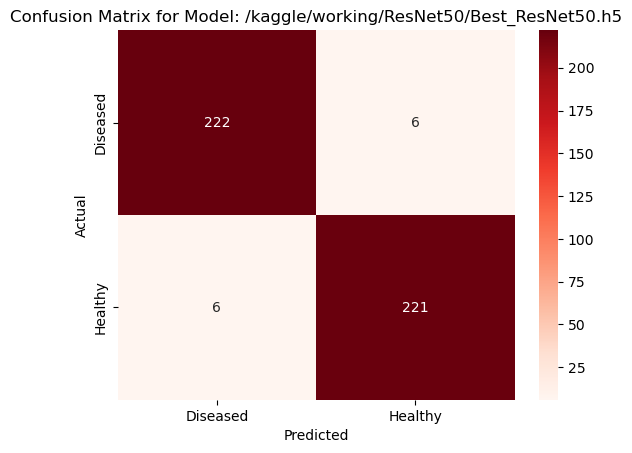

Test accuracy: 97.36263736263736
Model file path: /kaggle/working/ResNet50/50epoch.39-0.07.h5
1/1 [==============================] - 0s 23ms/step


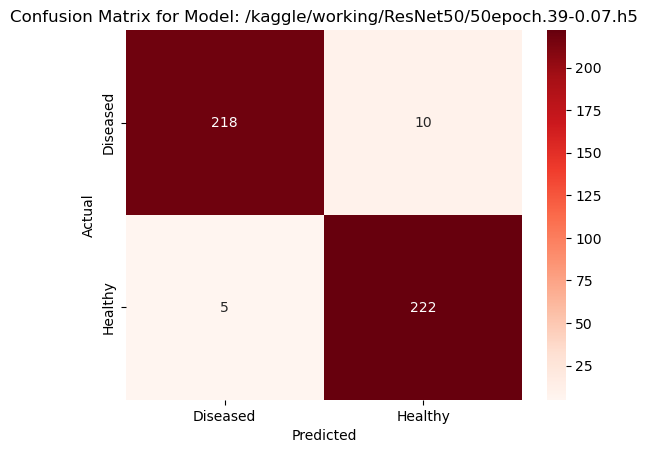

Test accuracy: 96.7032967032967


In [8]:
def main():
    train_generator, valid_generator, test_generator = get_data_generators()
    model = ResNetModel(train_generator.image_shape, train_generator.num_classes)
    history = compile_and_fit_model(model, train_generator, valid_generator)
    plot_training_history(history)
    save_best_model()
    evaluate_models(test_generator, train_generator)

if __name__ == "__main__":
    main()
